In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_sinkhorn_decay, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=123456789)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=1000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=300)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=10)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=300, num_examples=524288, random_seed=123456789, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=10, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=1000)

In [5]:
def generate_1x2_exp_data(num_examples, lambda_1, lambda_2):
    item_one = np.random.exponential(scale=1/lambda_1, size=(num_examples, 1, 1))
    item_two = np.random.exponential(scale=1/lambda_2, size=(num_examples, 1, 1))
    item_one = torch.from_numpy(item_one)
    item_two = torch.from_numpy(item_two)
    
    return torch.cat([item_one, item_two], dim=-1).type(torch.float)

In [6]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = torch.tensor([[[0., np.inf],
                            [0., np.inf]]])
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds, marginal_choice='additive'
).to(device)

train_data = generate_1x2_exp_data(args.num_examples, 2.0, 1.0).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [7]:
%%time
mean_rgt, mean_pay, lagr_mults = train_loop(model, train_loader, args, device=device)
# mean_rgt, mean_pay, lagr_mults = train_loop_sinkhorn_decay(model, train_loader, args, device=device, decay_iter=500, decay_mult=.99)

  0%|          | 1/300 [00:39<3:19:18, 40.00s/it]

{'regret_max': 2.743532657623291, 'regret_mean': 0.027530264109373093, 'regret_mults': tensor([[5.4181]], device='cuda:0'), 'payment': 0.5627189874649048}


  1%|          | 2/300 [01:19<3:18:27, 39.96s/it]

{'regret_max': 0.25798940658569336, 'regret_mean': 0.007708278484642506, 'regret_mults': tensor([[6.0983]], device='cuda:0'), 'payment': 0.6378394365310669}


  1%|          | 3/300 [01:59<3:17:57, 39.99s/it]

{'regret_max': 0.2439117431640625, 'regret_mean': 0.006904321722686291, 'regret_mults': tensor([[7.2855]], device='cuda:0'), 'payment': 0.633665144443512}


  1%|▏         | 4/300 [02:39<3:17:22, 40.01s/it]

{'regret_max': 0.27335596084594727, 'regret_mean': 0.0056358459405601025, 'regret_mults': tensor([[10.0850]], device='cuda:0'), 'payment': 0.6270937919616699}


  2%|▏         | 5/300 [03:19<3:16:43, 40.01s/it]

{'regret_max': 0.18628215789794922, 'regret_mean': 0.004825165029615164, 'regret_mults': tensor([[11.1372]], device='cuda:0'), 'payment': 0.6211267709732056}


  2%|▏         | 6/300 [04:00<3:16:24, 40.08s/it]

{'regret_max': 0.13701534271240234, 'regret_mean': 0.003967567812651396, 'regret_mults': tensor([[12.3289]], device='cuda:0'), 'payment': 0.6177553534507751}


  2%|▏         | 7/300 [04:40<3:16:06, 40.16s/it]

{'regret_max': 0.1618947982788086, 'regret_mean': 0.003502535168081522, 'regret_mults': tensor([[13.2996]], device='cuda:0'), 'payment': 0.61420738697052}


  3%|▎         | 8/300 [05:20<3:15:38, 40.20s/it]

{'regret_max': 0.15546178817749023, 'regret_mean': 0.0030560195446014404, 'regret_mults': tensor([[16.1577]], device='cuda:0'), 'payment': 0.6118524074554443}


  3%|▎         | 9/300 [06:01<3:15:13, 40.25s/it]

{'regret_max': 0.17163753509521484, 'regret_mean': 0.002968713641166687, 'regret_mults': tensor([[16.9719]], device='cuda:0'), 'payment': 0.6077569723129272}


  3%|▎         | 10/300 [06:42<3:16:04, 40.57s/it]

{'regret_max': 0.1263875961303711, 'regret_mean': 0.0025256704539060593, 'regret_mults': tensor([[17.6473]], device='cuda:0'), 'payment': 0.6059196591377258}


  4%|▎         | 11/300 [07:23<3:15:23, 40.57s/it]

{'regret_max': 0.12733983993530273, 'regret_mean': 0.0022425660863518715, 'regret_mults': tensor([[19.4889]], device='cuda:0'), 'payment': 0.6019936800003052}


  4%|▍         | 12/300 [08:02<3:12:59, 40.21s/it]

{'regret_max': 0.1004323959350586, 'regret_mean': 0.001468144473619759, 'regret_mults': tensor([[20.4169]], device='cuda:0'), 'payment': 0.6020222902297974}


  4%|▍         | 13/300 [08:41<3:10:55, 39.91s/it]

{'regret_max': 0.12979888916015625, 'regret_mean': 0.00210973690263927, 'regret_mults': tensor([[21.4468]], device='cuda:0'), 'payment': 0.5977969765663147}


  5%|▍         | 14/300 [09:20<3:09:10, 39.69s/it]

{'regret_max': 0.13241338729858398, 'regret_mean': 0.00131584785412997, 'regret_mults': tensor([[22.0036]], device='cuda:0'), 'payment': 0.5989490747451782}


  5%|▌         | 15/300 [09:59<3:07:33, 39.49s/it]

{'regret_max': 0.10858535766601562, 'regret_mean': 0.0013223026180639863, 'regret_mults': tensor([[24.7180]], device='cuda:0'), 'payment': 0.5936028957366943}


  5%|▌         | 16/300 [10:39<3:06:28, 39.40s/it]

{'regret_max': 0.13183927536010742, 'regret_mean': 0.001346975564956665, 'regret_mults': tensor([[25.8724]], device='cuda:0'), 'payment': 0.5930478572845459}


  6%|▌         | 17/300 [11:18<3:05:12, 39.27s/it]

{'regret_max': 0.16644573211669922, 'regret_mean': 0.0013080367352813482, 'regret_mults': tensor([[26.2249]], device='cuda:0'), 'payment': 0.5914921164512634}


  6%|▌         | 18/300 [11:57<3:04:13, 39.20s/it]

{'regret_max': 0.09812164306640625, 'regret_mean': 0.0011164476163685322, 'regret_mults': tensor([[27.9894]], device='cuda:0'), 'payment': 0.5922560691833496}


  6%|▋         | 19/300 [12:35<3:03:07, 39.10s/it]

{'regret_max': 0.07674884796142578, 'regret_mean': 0.0007526724366471171, 'regret_mults': tensor([[28.5261]], device='cuda:0'), 'payment': 0.5945110321044922}


  7%|▋         | 20/300 [13:15<3:02:37, 39.13s/it]

{'regret_max': 0.07951736450195312, 'regret_mean': 0.0008070828625932336, 'regret_mults': tensor([[28.9904]], device='cuda:0'), 'payment': 0.5941050052642822}


  7%|▋         | 21/300 [13:54<3:01:45, 39.09s/it]

{'regret_max': 0.10768461227416992, 'regret_mean': 0.0009213229059241712, 'regret_mults': tensor([[29.3881]], device='cuda:0'), 'payment': 0.5920741558074951}


  7%|▋         | 22/300 [14:33<3:01:08, 39.10s/it]

{'regret_max': 0.12345600128173828, 'regret_mean': 0.0011048640590161085, 'regret_mults': tensor([[32.3693]], device='cuda:0'), 'payment': 0.5925118923187256}


  8%|▊         | 23/300 [15:12<3:00:42, 39.14s/it]

{'regret_max': 0.09502410888671875, 'regret_mean': 0.0005538467084988952, 'regret_mults': tensor([[32.7742]], device='cuda:0'), 'payment': 0.5945929288864136}


  8%|▊         | 24/300 [15:51<2:59:56, 39.12s/it]

{'regret_max': 0.09058189392089844, 'regret_mean': 0.001132753910496831, 'regret_mults': tensor([[33.5233]], device='cuda:0'), 'payment': 0.5900328159332275}


  8%|▊         | 25/300 [16:30<2:59:30, 39.17s/it]

{'regret_max': 0.1756582260131836, 'regret_mean': 0.00133655802346766, 'regret_mults': tensor([[34.6146]], device='cuda:0'), 'payment': 0.585830807685852}


  9%|▊         | 26/300 [17:10<2:58:57, 39.19s/it]

{'regret_max': 0.04994630813598633, 'regret_mean': 0.0005203686887398362, 'regret_mults': tensor([[36.0880]], device='cuda:0'), 'payment': 0.59283846616745}


  9%|▉         | 27/300 [17:49<2:58:16, 39.18s/it]

{'regret_max': 0.10271835327148438, 'regret_mean': 0.0005091226194053888, 'regret_mults': tensor([[37.4911]], device='cuda:0'), 'payment': 0.5920010805130005}


  9%|▉         | 28/300 [18:28<2:57:42, 39.20s/it]

{'regret_max': 0.08347177505493164, 'regret_mean': 0.0005874115158803761, 'regret_mults': tensor([[37.7274]], device='cuda:0'), 'payment': 0.5926688313484192}


 10%|▉         | 29/300 [19:07<2:56:55, 39.17s/it]

{'regret_max': 0.09886693954467773, 'regret_mean': 0.000879312283359468, 'regret_mults': tensor([[38.9784]], device='cuda:0'), 'payment': 0.5901092290878296}


 10%|█         | 30/300 [19:46<2:56:04, 39.13s/it]

{'regret_max': 0.10807991027832031, 'regret_mean': 0.0003815056406892836, 'regret_mults': tensor([[39.1534]], device='cuda:0'), 'payment': 0.5943399667739868}


 10%|█         | 31/300 [20:25<2:55:12, 39.08s/it]

{'regret_max': 0.10371160507202148, 'regret_mean': 0.0005871504545211792, 'regret_mults': tensor([[39.4947]], device='cuda:0'), 'payment': 0.5926474928855896}


 11%|█         | 32/300 [21:04<2:54:32, 39.08s/it]

{'regret_max': 0.33750247955322266, 'regret_mean': 0.0037598563358187675, 'regret_mults': tensor([[42.4479]], device='cuda:0'), 'payment': 0.5651397109031677}


 11%|█         | 33/300 [21:43<2:53:51, 39.07s/it]

{'regret_max': 0.11437273025512695, 'regret_mean': 0.000403186131734401, 'regret_mults': tensor([[46.9868]], device='cuda:0'), 'payment': 0.586428701877594}


 11%|█▏        | 34/300 [22:22<2:53:15, 39.08s/it]

{'regret_max': 0.05803871154785156, 'regret_mean': 0.00024161238980013877, 'regret_mults': tensor([[47.2650]], device='cuda:0'), 'payment': 0.5922493934631348}


 12%|█▏        | 35/300 [23:02<2:52:47, 39.12s/it]

{'regret_max': 0.06895971298217773, 'regret_mean': 0.0004003611393272877, 'regret_mults': tensor([[47.8258]], device='cuda:0'), 'payment': 0.5921351909637451}


 12%|█▏        | 36/300 [23:41<2:52:00, 39.09s/it]

{'regret_max': 0.0974884033203125, 'regret_mean': 0.0004917467595078051, 'regret_mults': tensor([[48.7502]], device='cuda:0'), 'payment': 0.590333104133606}


 12%|█▏        | 37/300 [24:20<2:51:27, 39.11s/it]

{'regret_max': 0.153045654296875, 'regret_mean': 0.000946409534662962, 'regret_mults': tensor([[73.1088]], device='cuda:0'), 'payment': 0.5820506811141968}


 13%|█▎        | 38/300 [24:59<2:50:48, 39.12s/it]

{'regret_max': 0.07673883438110352, 'regret_mean': 0.0002526253229007125, 'regret_mults': tensor([[73.2931]], device='cuda:0'), 'payment': 0.5813195705413818}


 13%|█▎        | 39/300 [25:38<2:50:10, 39.12s/it]

{'regret_max': 0.18581867218017578, 'regret_mean': 0.0010618362575769424, 'regret_mults': tensor([[73.5078]], device='cuda:0'), 'payment': 0.5681936740875244}


 13%|█▎        | 40/300 [26:17<2:49:44, 39.17s/it]

{'regret_max': 0.13074111938476562, 'regret_mean': 0.0004797589499503374, 'regret_mults': tensor([[74.0594]], device='cuda:0'), 'payment': 0.5769069194793701}


 14%|█▎        | 41/300 [26:57<2:49:18, 39.22s/it]

{'regret_max': 0.06932544708251953, 'regret_mean': 0.00022092420840635896, 'regret_mults': tensor([[75.6872]], device='cuda:0'), 'payment': 0.5866955518722534}


 14%|█▍        | 42/300 [27:36<2:48:38, 39.22s/it]

{'regret_max': 0.14080190658569336, 'regret_mean': 0.0005945874145254493, 'regret_mults': tensor([[75.9324]], device='cuda:0'), 'payment': 0.5828007459640503}


 14%|█▍        | 43/300 [28:15<2:48:10, 39.26s/it]

{'regret_max': 0.06494283676147461, 'regret_mean': 0.00017047861183527857, 'regret_mults': tensor([[76.3883]], device='cuda:0'), 'payment': 0.5891972780227661}


 15%|█▍        | 44/300 [28:55<2:47:55, 39.36s/it]

{'regret_max': 0.2054271697998047, 'regret_mean': 0.0008883543778210878, 'regret_mults': tensor([[76.5835]], device='cuda:0'), 'payment': 0.5699382424354553}


 15%|█▌        | 45/300 [29:34<2:47:05, 39.31s/it]

{'regret_max': 0.13154125213623047, 'regret_mean': 0.0004969927249476314, 'regret_mults': tensor([[78.6543]], device='cuda:0'), 'payment': 0.5787490606307983}


 15%|█▌        | 46/300 [30:13<2:45:57, 39.20s/it]

{'regret_max': 0.06841516494750977, 'regret_mean': 0.00028502760687842965, 'regret_mults': tensor([[78.8673]], device='cuda:0'), 'payment': 0.5858388543128967}


 16%|█▌        | 47/300 [30:52<2:45:18, 39.20s/it]

{'regret_max': 0.05788707733154297, 'regret_mean': 0.00025374855613335967, 'regret_mults': tensor([[79.6900]], device='cuda:0'), 'payment': 0.5885395407676697}


 16%|█▌        | 48/300 [31:31<2:44:26, 39.15s/it]

{'regret_max': 0.07856321334838867, 'regret_mean': 0.00021516979904845357, 'regret_mults': tensor([[80.9303]], device='cuda:0'), 'payment': 0.5895273089408875}


 16%|█▋        | 49/300 [32:10<2:43:48, 39.16s/it]

{'regret_max': 0.12037467956542969, 'regret_mean': 0.0005917777307331562, 'regret_mults': tensor([[90.6353]], device='cuda:0'), 'payment': 0.5790708065032959}


 17%|█▋        | 50/300 [32:50<2:43:34, 39.26s/it]

{'regret_max': 0.0662841796875, 'regret_mean': 0.00024852383648976684, 'regret_mults': tensor([[91.0428]], device='cuda:0'), 'payment': 0.5859246253967285}


 17%|█▋        | 51/300 [33:29<2:42:56, 39.26s/it]

{'regret_max': 0.1205902099609375, 'regret_mean': 0.0005937216337770224, 'regret_mults': tensor([[91.7813]], device='cuda:0'), 'payment': 0.578809380531311}


 17%|█▋        | 52/300 [34:09<2:42:50, 39.40s/it]

{'regret_max': 0.03223896026611328, 'regret_mean': 0.00020127743482589722, 'regret_mults': tensor([[93.5089]], device='cuda:0'), 'payment': 0.5851986408233643}


 18%|█▊        | 53/300 [34:50<2:43:51, 39.80s/it]

{'regret_max': 0.29865598678588867, 'regret_mean': 0.0033045480959117413, 'regret_mults': tensor([[95.6796]], device='cuda:0'), 'payment': 0.5615030527114868}


 18%|█▊        | 54/300 [35:28<2:41:50, 39.47s/it]

{'regret_max': 0.13580703735351562, 'regret_mean': 0.00010839934111572802, 'regret_mults': tensor([[96.5092]], device='cuda:0'), 'payment': 0.5709401369094849}


 18%|█▊        | 55/300 [36:07<2:39:42, 39.11s/it]

{'regret_max': 0.09429740905761719, 'regret_mean': 0.00016730887000449002, 'regret_mults': tensor([[96.6995]], device='cuda:0'), 'payment': 0.5834552645683289}


 19%|█▊        | 56/300 [36:45<2:38:11, 38.90s/it]

{'regret_max': 0.13054227828979492, 'regret_mean': 0.0007657826063223183, 'regret_mults': tensor([[97.7496]], device='cuda:0'), 'payment': 0.5656284093856812}


 19%|█▉        | 57/300 [37:23<2:36:35, 38.67s/it]

{'regret_max': 0.09342765808105469, 'regret_mean': 6.030052463756874e-05, 'regret_mults': tensor([[97.9643]], device='cuda:0'), 'payment': 0.5855956673622131}


 19%|█▉        | 58/300 [38:01<2:35:24, 38.53s/it]

{'regret_max': 0.21357202529907227, 'regret_mean': 0.000937052711378783, 'regret_mults': tensor([[98.7612]], device='cuda:0'), 'payment': 0.5647785663604736}


 20%|█▉        | 59/300 [38:40<2:34:25, 38.45s/it]

{'regret_max': 0.08640766143798828, 'regret_mean': 6.215539178811014e-05, 'regret_mults': tensor([[98.9645]], device='cuda:0'), 'payment': 0.5790506601333618}


 20%|██        | 60/300 [39:18<2:33:35, 38.40s/it]

{'regret_max': 0.12070274353027344, 'regret_mean': 0.00039453519275411963, 'regret_mults': tensor([[99.1863]], device='cuda:0'), 'payment': 0.5839782357215881}


 20%|██        | 61/300 [39:56<2:32:51, 38.38s/it]

{'regret_max': 0.06047344207763672, 'regret_mean': 5.4831005400046706e-05, 'regret_mults': tensor([[99.6135]], device='cuda:0'), 'payment': 0.5853692293167114}


 21%|██        | 62/300 [40:34<2:32:11, 38.37s/it]

{'regret_max': 0.08833026885986328, 'regret_mean': 0.0002236116270069033, 'regret_mults': tensor([[99.9648]], device='cuda:0'), 'payment': 0.587826132774353}


 21%|██        | 63/300 [41:13<2:31:26, 38.34s/it]

{'regret_max': 0.06385612487792969, 'regret_mean': 0.00020155755919404328, 'regret_mults': tensor([[100.5711]], device='cuda:0'), 'payment': 0.5890164375305176}


 21%|██▏       | 64/300 [41:51<2:30:45, 38.33s/it]

{'regret_max': 0.08769989013671875, 'regret_mean': 0.0001622192794457078, 'regret_mults': tensor([[100.8454]], device='cuda:0'), 'payment': 0.5903496742248535}


 22%|██▏       | 65/300 [42:30<2:30:24, 38.40s/it]

{'regret_max': 0.07004594802856445, 'regret_mean': 0.00025859527522698045, 'regret_mults': tensor([[102.2114]], device='cuda:0'), 'payment': 0.5863814353942871}


 22%|██▏       | 66/300 [43:08<2:29:38, 38.37s/it]

{'regret_max': 0.23501300811767578, 'regret_mean': 0.0012227818369865417, 'regret_mults': tensor([[102.5212]], device='cuda:0'), 'payment': 0.5763948559761047}


 22%|██▏       | 67/300 [43:46<2:28:57, 38.36s/it]

{'regret_max': 0.04779815673828125, 'regret_mean': 0.00014205757179297507, 'regret_mults': tensor([[102.8783]], device='cuda:0'), 'payment': 0.5593558549880981}


 23%|██▎       | 68/300 [44:25<2:28:18, 38.35s/it]

{'regret_max': 0.0740056037902832, 'regret_mean': 0.00017844524700194597, 'regret_mults': tensor([[103.4410]], device='cuda:0'), 'payment': 0.5854901075363159}


 23%|██▎       | 69/300 [45:03<2:27:36, 38.34s/it]

{'regret_max': 0.07559967041015625, 'regret_mean': 0.00016291305655613542, 'regret_mults': tensor([[104.7891]], device='cuda:0'), 'payment': 0.5887278318405151}


 23%|██▎       | 70/300 [45:41<2:26:51, 38.31s/it]

{'regret_max': 0.1139059066772461, 'regret_mean': 0.0003731976030394435, 'regret_mults': tensor([[117.5921]], device='cuda:0'), 'payment': 0.577905535697937}


 24%|██▎       | 71/300 [46:20<2:26:19, 38.34s/it]

{'regret_max': 0.05308961868286133, 'regret_mean': 7.904254016466439e-05, 'regret_mults': tensor([[117.8093]], device='cuda:0'), 'payment': 0.5862523317337036}


 24%|██▍       | 72/300 [46:58<2:25:45, 38.36s/it]

{'regret_max': 0.09779834747314453, 'regret_mean': 0.00036068656481802464, 'regret_mults': tensor([[127.0865]], device='cuda:0'), 'payment': 0.5727170705795288}


 24%|██▍       | 73/300 [47:36<2:25:16, 38.40s/it]

{'regret_max': 0.13588619232177734, 'regret_mean': 0.0005932946223765612, 'regret_mults': tensor([[131.8021]], device='cuda:0'), 'payment': 0.5733404159545898}


 25%|██▍       | 74/300 [48:15<2:24:43, 38.42s/it]

{'regret_max': 0.09254932403564453, 'regret_mean': 0.000259156251559034, 'regret_mults': tensor([[132.0582]], device='cuda:0'), 'payment': 0.5793386101722717}


 25%|██▌       | 75/300 [48:53<2:24:06, 38.43s/it]

{'regret_max': 0.04566764831542969, 'regret_mean': 7.929341518320143e-05, 'regret_mults': tensor([[132.7347]], device='cuda:0'), 'payment': 0.5784357190132141}


 25%|██▌       | 76/300 [49:32<2:23:22, 38.40s/it]

{'regret_max': 0.0725393295288086, 'regret_mean': 0.00013129750732332468, 'regret_mults': tensor([[132.9301]], device='cuda:0'), 'payment': 0.5885844230651855}


 26%|██▌       | 77/300 [50:10<2:22:42, 38.40s/it]

{'regret_max': 0.09528541564941406, 'regret_mean': 0.0003751767799258232, 'regret_mults': tensor([[133.1118]], device='cuda:0'), 'payment': 0.5741094350814819}


 26%|██▌       | 78/300 [50:49<2:22:11, 38.43s/it]

{'regret_max': 0.12671375274658203, 'regret_mean': 0.0005556479445658624, 'regret_mults': tensor([[142.4349]], device='cuda:0'), 'payment': 0.5678311586380005}


 26%|██▋       | 79/300 [51:27<2:21:32, 38.43s/it]

{'regret_max': 0.07845115661621094, 'regret_mean': 0.0002906442678067833, 'regret_mults': tensor([[143.3266]], device='cuda:0'), 'payment': 0.5784857869148254}


 27%|██▋       | 80/300 [52:06<2:21:09, 38.50s/it]

{'regret_max': 0.07592535018920898, 'regret_mean': 0.00019418644660618156, 'regret_mults': tensor([[143.5316]], device='cuda:0'), 'payment': 0.5834254026412964}


 27%|██▋       | 81/300 [52:44<2:20:43, 38.56s/it]

{'regret_max': 0.05280303955078125, 'regret_mean': 7.433978316839784e-05, 'regret_mults': tensor([[143.7125]], device='cuda:0'), 'payment': 0.5814876556396484}


 27%|██▋       | 82/300 [53:23<2:19:49, 38.48s/it]

{'regret_max': 0.056835174560546875, 'regret_mean': 0.00021084534819237888, 'regret_mults': tensor([[146.4344]], device='cuda:0'), 'payment': 0.5826027393341064}


 28%|██▊       | 83/300 [54:01<2:19:09, 38.48s/it]

{'regret_max': 0.05861473083496094, 'regret_mean': 0.0001426753879059106, 'regret_mults': tensor([[146.7601]], device='cuda:0'), 'payment': 0.5858821868896484}


 28%|██▊       | 84/300 [54:40<2:18:33, 38.49s/it]

{'regret_max': 0.14803123474121094, 'regret_mean': 0.001077041495591402, 'regret_mults': tensor([[147.8418]], device='cuda:0'), 'payment': 0.5549476146697998}


 28%|██▊       | 85/300 [55:18<2:17:55, 38.49s/it]

{'regret_max': 0.10497522354125977, 'regret_mean': 0.00022435167920775712, 'regret_mults': tensor([[148.1042]], device='cuda:0'), 'payment': 0.5779097676277161}


 29%|██▊       | 86/300 [55:57<2:17:21, 38.51s/it]

{'regret_max': 0.036408424377441406, 'regret_mean': 5.0447575631551445e-05, 'regret_mults': tensor([[148.8729]], device='cuda:0'), 'payment': 0.5790806412696838}


 29%|██▉       | 87/300 [56:35<2:16:43, 38.51s/it]

{'regret_max': 0.09324073791503906, 'regret_mean': 0.0002599834406282753, 'regret_mults': tensor([[149.0698]], device='cuda:0'), 'payment': 0.5750495791435242}


 29%|██▉       | 88/300 [57:14<2:16:12, 38.55s/it]

{'regret_max': 0.07218265533447266, 'regret_mean': 0.00032944127451628447, 'regret_mults': tensor([[149.3333]], device='cuda:0'), 'payment': 0.5806313753128052}


 30%|██▉       | 89/300 [57:52<2:15:25, 38.51s/it]

{'regret_max': 0.03245258331298828, 'regret_mean': 4.0054954297374934e-05, 'regret_mults': tensor([[149.5589]], device='cuda:0'), 'payment': 0.5814357399940491}


 30%|███       | 90/300 [58:31<2:15:07, 38.61s/it]

{'regret_max': 0.0626840591430664, 'regret_mean': 0.00018524928600527346, 'regret_mults': tensor([[150.0180]], device='cuda:0'), 'payment': 0.5832396745681763}


 30%|███       | 91/300 [59:10<2:14:33, 38.63s/it]

{'regret_max': 0.6580274105072021, 'regret_mean': 0.007298770826309919, 'regret_mults': tensor([[263.3164]], device='cuda:0'), 'payment': 0.5356109738349915}


 31%|███       | 92/300 [59:49<2:14:12, 38.71s/it]

{'regret_max': 0.1803569793701172, 'regret_mean': 9.290694288210943e-05, 'regret_mults': tensor([[263.7428]], device='cuda:0'), 'payment': 0.48956549167633057}


 31%|███       | 93/300 [1:00:28<2:13:59, 38.84s/it]

{'regret_max': 0.16213417053222656, 'regret_mean': 3.421874134801328e-05, 'regret_mults': tensor([[264.1516]], device='cuda:0'), 'payment': 0.5252989530563354}


 31%|███▏      | 94/300 [1:01:07<2:13:35, 38.91s/it]

{'regret_max': 0.15552806854248047, 'regret_mean': 2.6642468583304435e-05, 'regret_mults': tensor([[264.2825]], device='cuda:0'), 'payment': 0.5465129613876343}


 32%|███▏      | 95/300 [1:01:47<2:14:08, 39.26s/it]

{'regret_max': 0.1414804458618164, 'regret_mean': 4.18637901020702e-05, 'regret_mults': tensor([[264.5640]], device='cuda:0'), 'payment': 0.5584748983383179}


 32%|███▏      | 96/300 [1:02:26<2:13:05, 39.15s/it]

{'regret_max': 0.13667869567871094, 'regret_mean': 4.548121796688065e-05, 'regret_mults': tensor([[264.9686]], device='cuda:0'), 'payment': 0.5651949048042297}


 32%|███▏      | 97/300 [1:03:04<2:11:15, 38.80s/it]

{'regret_max': 0.1265878677368164, 'regret_mean': 7.602664845762774e-05, 'regret_mults': tensor([[265.4027]], device='cuda:0'), 'payment': 0.5685034990310669}


 33%|███▎      | 98/300 [1:03:42<2:09:53, 38.58s/it]

{'regret_max': 0.40265655517578125, 'regret_mean': 0.0038755747955292463, 'regret_mults': tensor([[265.6152]], device='cuda:0'), 'payment': 0.5611196160316467}


 33%|███▎      | 99/300 [1:04:20<2:09:00, 38.51s/it]

{'regret_max': 0.17497825622558594, 'regret_mean': 0.0011044391430914402, 'regret_mults': tensor([[267.0449]], device='cuda:0'), 'payment': 0.42602694034576416}


 33%|███▎      | 100/300 [1:04:58<2:07:59, 38.40s/it]

{'regret_max': 0.10435962677001953, 'regret_mean': 4.918930062558502e-05, 'regret_mults': tensor([[267.6132]], device='cuda:0'), 'payment': 0.47072410583496094}


 34%|███▎      | 101/300 [1:05:37<2:07:12, 38.35s/it]

{'regret_max': 0.10320472717285156, 'regret_mean': 2.679067983990535e-05, 'regret_mults': tensor([[267.7620]], device='cuda:0'), 'payment': 0.5111381411552429}


 34%|███▍      | 102/300 [1:06:15<2:06:25, 38.31s/it]

{'regret_max': 0.09853267669677734, 'regret_mean': 2.1397938326117583e-05, 'regret_mults': tensor([[267.9025]], device='cuda:0'), 'payment': 0.5371906161308289}


 34%|███▍      | 103/300 [1:06:53<2:05:41, 38.28s/it]

{'regret_max': 0.09373092651367188, 'regret_mean': 1.929467180161737e-05, 'regret_mults': tensor([[268.0237]], device='cuda:0'), 'payment': 0.5545225143432617}


 35%|███▍      | 104/300 [1:07:31<2:04:39, 38.16s/it]

{'regret_max': 0.08182525634765625, 'regret_mean': 9.228396811522543e-05, 'regret_mults': tensor([[268.3799]], device='cuda:0'), 'payment': 0.5645765662193298}


 35%|███▌      | 105/300 [1:08:09<2:03:56, 38.14s/it]

{'regret_max': 0.0819406509399414, 'regret_mean': 2.4399536414421163e-05, 'regret_mults': tensor([[268.5240]], device='cuda:0'), 'payment': 0.5719975233078003}


 35%|███▌      | 106/300 [1:08:47<2:03:28, 38.19s/it]

{'regret_max': 0.05622577667236328, 'regret_mean': 0.00010141701204702258, 'regret_mults': tensor([[268.7155]], device='cuda:0'), 'payment': 0.5755095481872559}


 36%|███▌      | 107/300 [1:09:26<2:02:50, 38.19s/it]

{'regret_max': 0.06194925308227539, 'regret_mean': 5.924855940975249e-05, 'regret_mults': tensor([[268.8306]], device='cuda:0'), 'payment': 0.579603910446167}


 36%|███▌      | 108/300 [1:10:04<2:02:04, 38.15s/it]

{'regret_max': 0.08372211456298828, 'regret_mean': 0.00019707898900378495, 'regret_mults': tensor([[278.8006]], device='cuda:0'), 'payment': 0.5726159811019897}


 36%|███▋      | 109/300 [1:10:42<2:01:28, 38.16s/it]

{'regret_max': 0.055193424224853516, 'regret_mean': 0.000303884269669652, 'regret_mults': tensor([[279.7665]], device='cuda:0'), 'payment': 0.5763776302337646}


 37%|███▋      | 110/300 [1:11:20<2:00:43, 38.12s/it]

{'regret_max': 0.05093097686767578, 'regret_mean': 2.0135918020969257e-05, 'regret_mults': tensor([[279.8780]], device='cuda:0'), 'payment': 0.5772764682769775}


 37%|███▋      | 111/300 [1:11:58<2:00:07, 38.13s/it]

{'regret_max': 0.10482263565063477, 'regret_mean': 0.0006383027648553252, 'regret_mults': tensor([[280.3244]], device='cuda:0'), 'payment': 0.5665425062179565}


 37%|███▋      | 112/300 [1:12:36<1:59:34, 38.16s/it]

{'regret_max': 0.0551910400390625, 'regret_mean': 2.1072217350592837e-05, 'regret_mults': tensor([[280.4490]], device='cuda:0'), 'payment': 0.568233847618103}


 38%|███▊      | 113/300 [1:13:14<1:58:54, 38.15s/it]

{'regret_max': 0.04868888854980469, 'regret_mean': 1.7171048966702074e-05, 'regret_mults': tensor([[280.5769]], device='cuda:0'), 'payment': 0.582116425037384}


 38%|███▊      | 114/300 [1:13:53<1:58:20, 38.17s/it]

{'regret_max': 0.052156925201416016, 'regret_mean': 0.00015751692990306765, 'regret_mults': tensor([[281.9051]], device='cuda:0'), 'payment': 0.5769693851470947}


 38%|███▊      | 115/300 [1:14:31<1:57:53, 38.23s/it]

{'regret_max': 0.033111572265625, 'regret_mean': 1.7242671674466692e-05, 'regret_mults': tensor([[282.1643]], device='cuda:0'), 'payment': 0.5830066204071045}


 39%|███▊      | 116/300 [1:15:09<1:57:15, 38.24s/it]

{'regret_max': 0.08701562881469727, 'regret_mean': 0.00040757638635113835, 'regret_mults': tensor([[283.1152]], device='cuda:0'), 'payment': 0.5633658170700073}


 39%|███▉      | 117/300 [1:15:47<1:56:34, 38.22s/it]

{'regret_max': 0.03677845001220703, 'regret_mean': 1.7394117094227113e-05, 'regret_mults': tensor([[283.2367]], device='cuda:0'), 'payment': 0.5767343640327454}


 39%|███▉      | 118/300 [1:16:26<1:55:57, 38.23s/it]

{'regret_max': 0.04936647415161133, 'regret_mean': 0.00013321166625246406, 'regret_mults': tensor([[283.7466]], device='cuda:0'), 'payment': 0.5825775861740112}


 40%|███▉      | 119/300 [1:17:04<1:55:24, 38.26s/it]

{'regret_max': 0.02541351318359375, 'regret_mean': 2.0398820197442546e-05, 'regret_mults': tensor([[283.8724]], device='cuda:0'), 'payment': 0.580208420753479}


 40%|████      | 120/300 [1:17:42<1:54:47, 38.26s/it]

{'regret_max': 0.08664464950561523, 'regret_mean': 0.00029819656629115343, 'regret_mults': tensor([[287.5063]], device='cuda:0'), 'payment': 0.5729566216468811}


 40%|████      | 121/300 [1:18:21<1:54:17, 38.31s/it]

{'regret_max': 0.018507957458496094, 'regret_mean': 1.635957414691802e-05, 'regret_mults': tensor([[287.6166]], device='cuda:0'), 'payment': 0.5824347138404846}


 41%|████      | 122/300 [1:18:59<1:53:37, 38.30s/it]

{'regret_max': 0.04651832580566406, 'regret_mean': 0.0001436574530089274, 'regret_mults': tensor([[288.6391]], device='cuda:0'), 'payment': 0.5780976414680481}


 41%|████      | 123/300 [1:19:37<1:53:04, 38.33s/it]

{'regret_max': 0.11576414108276367, 'regret_mean': 0.0006980700418353081, 'regret_mults': tensor([[320.7435]], device='cuda:0'), 'payment': 0.5641832947731018}


 41%|████▏     | 124/300 [1:20:16<1:52:36, 38.39s/it]

{'regret_max': 0.027085304260253906, 'regret_mean': 2.8600992663996294e-05, 'regret_mults': tensor([[320.9292]], device='cuda:0'), 'payment': 0.5611546039581299}


 42%|████▏     | 125/300 [1:20:54<1:52:05, 38.43s/it]

{'regret_max': 0.10239028930664062, 'regret_mean': 5.813595635117963e-05, 'regret_mults': tensor([[329.7242]], device='cuda:0'), 'payment': 0.5815637707710266}


 42%|████▏     | 126/300 [1:21:33<1:51:35, 38.48s/it]

{'regret_max': 0.13527870178222656, 'regret_mean': 0.00021244620438665152, 'regret_mults': tensor([[329.8400]], device='cuda:0'), 'payment': 0.562252402305603}


 42%|████▏     | 127/300 [1:22:12<1:51:05, 38.53s/it]

{'regret_max': 0.037535667419433594, 'regret_mean': 1.9609742594184354e-05, 'regret_mults': tensor([[329.9778]], device='cuda:0'), 'payment': 0.5806612968444824}


 43%|████▎     | 128/300 [1:22:50<1:50:30, 38.55s/it]

{'regret_max': 0.05569124221801758, 'regret_mean': 0.00015699677169322968, 'regret_mults': tensor([[330.5404]], device='cuda:0'), 'payment': 0.5743262767791748}


 43%|████▎     | 129/300 [1:23:29<1:49:49, 38.54s/it]

{'regret_max': 0.09926509857177734, 'regret_mean': 0.00031752290669828653, 'regret_mults': tensor([[331.4062]], device='cuda:0'), 'payment': 0.5756481289863586}


 43%|████▎     | 130/300 [1:24:07<1:49:13, 38.55s/it]

{'regret_max': 0.05949592590332031, 'regret_mean': 1.7496648069936782e-05, 'regret_mults': tensor([[331.5289]], device='cuda:0'), 'payment': 0.5729451775550842}


 44%|████▎     | 131/300 [1:24:46<1:48:55, 38.67s/it]

{'regret_max': 0.06501531600952148, 'regret_mean': 0.0003103083581663668, 'regret_mults': tensor([[331.6864]], device='cuda:0'), 'payment': 0.5721445679664612}


 44%|████▍     | 132/300 [1:25:25<1:48:16, 38.67s/it]

{'regret_max': 0.014094352722167969, 'regret_mean': 1.5572783013340086e-05, 'regret_mults': tensor([[331.8094]], device='cuda:0'), 'payment': 0.5739613771438599}


 44%|████▍     | 133/300 [1:26:04<1:47:48, 38.74s/it]

{'regret_max': 0.05556201934814453, 'regret_mean': 0.000186193676199764, 'regret_mults': tensor([[332.2738]], device='cuda:0'), 'payment': 0.5747009515762329}


 45%|████▍     | 134/300 [1:26:43<1:47:30, 38.86s/it]

{'regret_max': 0.02524566650390625, 'regret_mean': 1.4116112652118318e-05, 'regret_mults': tensor([[332.3879]], device='cuda:0'), 'payment': 0.5803969502449036}


 45%|████▌     | 135/300 [1:27:22<1:46:51, 38.85s/it]

{'regret_max': 0.19820404052734375, 'regret_mean': 0.0008386934641748667, 'regret_mults': tensor([[339.5807]], device='cuda:0'), 'payment': 0.5359775424003601}


 45%|████▌     | 136/300 [1:28:01<1:46:05, 38.82s/it]

{'regret_max': 0.0329742431640625, 'regret_mean': 2.12531303986907e-05, 'regret_mults': tensor([[339.9699]], device='cuda:0'), 'payment': 0.5694278478622437}


 46%|████▌     | 137/300 [1:28:39<1:45:28, 38.83s/it]

{'regret_max': 0.06985902786254883, 'regret_mean': 0.00031155202304944396, 'regret_mults': tensor([[340.1962]], device='cuda:0'), 'payment': 0.5477803945541382}


 46%|████▌     | 138/300 [1:29:20<1:46:39, 39.50s/it]

{'regret_max': 0.03829002380371094, 'regret_mean': 1.73216758412309e-05, 'regret_mults': tensor([[340.3643]], device='cuda:0'), 'payment': 0.5726531147956848}


 46%|████▋     | 139/300 [1:29:59<1:45:21, 39.27s/it]

{'regret_max': 0.08990764617919922, 'regret_mean': 0.00032646142062731087, 'regret_mults': tensor([[340.5353]], device='cuda:0'), 'payment': 0.5640830993652344}


 47%|████▋     | 140/300 [1:30:38<1:44:03, 39.02s/it]

{'regret_max': 0.02964496612548828, 'regret_mean': 1.5452696970896795e-05, 'regret_mults': tensor([[340.8350]], device='cuda:0'), 'payment': 0.57245272397995}


 47%|████▋     | 141/300 [1:31:16<1:42:34, 38.71s/it]

{'regret_max': 0.07271242141723633, 'regret_mean': 0.000242120266193524, 'regret_mults': tensor([[366.8160]], device='cuda:0'), 'payment': 0.5725364089012146}


 47%|████▋     | 142/300 [1:31:54<1:41:17, 38.47s/it]

{'regret_max': 0.0477142333984375, 'regret_mean': 1.4015133274369873e-05, 'regret_mults': tensor([[366.9490]], device='cuda:0'), 'payment': 0.5717105865478516}


 48%|████▊     | 143/300 [1:32:32<1:40:22, 38.36s/it]

{'regret_max': 0.10049057006835938, 'regret_mean': 0.00031022250186651945, 'regret_mults': tensor([[367.3558]], device='cuda:0'), 'payment': 0.5627094507217407}


 48%|████▊     | 144/300 [1:33:10<1:39:21, 38.22s/it]

{'regret_max': 0.017339706420898438, 'regret_mean': 1.471691211918369e-05, 'regret_mults': tensor([[367.4798]], device='cuda:0'), 'payment': 0.5673227310180664}


 48%|████▊     | 145/300 [1:33:47<1:38:32, 38.14s/it]

{'regret_max': 0.08010673522949219, 'regret_mean': 0.00031774898525327444, 'regret_mults': tensor([[390.6977]], device='cuda:0'), 'payment': 0.5649304389953613}


 49%|████▊     | 146/300 [1:34:26<1:37:51, 38.12s/it]

{'regret_max': 0.02397918701171875, 'regret_mean': 1.3211075383878779e-05, 'regret_mults': tensor([[390.8196]], device='cuda:0'), 'payment': 0.5690627694129944}


 49%|████▉     | 147/300 [1:35:04<1:37:08, 38.10s/it]

{'regret_max': 0.06196784973144531, 'regret_mean': 0.0001861406199168414, 'regret_mults': tensor([[391.0901]], device='cuda:0'), 'payment': 0.5700947046279907}


 49%|████▉     | 148/300 [1:35:42<1:36:26, 38.07s/it]

{'regret_max': 0.020982742309570312, 'regret_mean': 1.1189215911144856e-05, 'regret_mults': tensor([[391.1906]], device='cuda:0'), 'payment': 0.5764679312705994}


 50%|████▉     | 149/300 [1:36:20<1:35:51, 38.09s/it]

{'regret_max': 0.048056602478027344, 'regret_mean': 0.00010997898789355531, 'regret_mults': tensor([[392.3251]], device='cuda:0'), 'payment': 0.5744788646697998}


 50%|█████     | 150/300 [1:36:58<1:35:08, 38.06s/it]

{'regret_max': 0.025467872619628906, 'regret_mean': 1.1037866897822823e-05, 'regret_mults': tensor([[392.5429]], device='cuda:0'), 'payment': 0.5810754895210266}


 50%|█████     | 151/300 [1:37:36<1:34:27, 38.04s/it]

{'regret_max': 0.07823562622070312, 'regret_mean': 0.0007010373519733548, 'regret_mults': tensor([[392.7436]], device='cuda:0'), 'payment': 0.5446774959564209}


 51%|█████     | 152/300 [1:38:14<1:33:44, 38.00s/it]

{'regret_max': 0.08306217193603516, 'regret_mean': 1.4806596482230816e-05, 'regret_mults': tensor([[392.8740]], device='cuda:0'), 'payment': 0.5682588815689087}


 51%|█████     | 153/300 [1:38:52<1:33:14, 38.06s/it]

{'regret_max': 0.11619186401367188, 'regret_mean': 0.000239193657762371, 'regret_mults': tensor([[393.5327]], device='cuda:0'), 'payment': 0.5640035271644592}


 51%|█████▏    | 154/300 [1:39:30<1:32:35, 38.05s/it]

{'regret_max': 0.02533245086669922, 'regret_mean': 1.1813100172730628e-05, 'regret_mults': tensor([[393.7572]], device='cuda:0'), 'payment': 0.5700047016143799}


 52%|█████▏    | 155/300 [1:40:08<1:31:58, 38.06s/it]

{'regret_max': 0.061371803283691406, 'regret_mean': 0.00010157229553442448, 'regret_mults': tensor([[394.0623]], device='cuda:0'), 'payment': 0.5788507461547852}


 52%|█████▏    | 156/300 [1:40:46<1:31:28, 38.12s/it]

{'regret_max': 0.01665973663330078, 'regret_mean': 1.3727119949180633e-05, 'regret_mults': tensor([[394.1667]], device='cuda:0'), 'payment': 0.5739266872406006}


 52%|█████▏    | 157/300 [1:41:24<1:30:47, 38.10s/it]

{'regret_max': 0.12950611114501953, 'regret_mean': 0.00011493460624478757, 'regret_mults': tensor([[394.2688]], device='cuda:0'), 'payment': 0.5791023969650269}


 53%|█████▎    | 158/300 [1:42:02<1:30:05, 38.07s/it]

{'regret_max': 0.10681438446044922, 'regret_mean': 1.2310726560826879e-05, 'regret_mults': tensor([[394.6016]], device='cuda:0'), 'payment': 0.5771150588989258}


 53%|█████▎    | 159/300 [1:42:40<1:29:31, 38.10s/it]

{'regret_max': 0.1076059341430664, 'regret_mean': 9.898577991407365e-05, 'regret_mults': tensor([[397.2412]], device='cuda:0'), 'payment': 0.5801616311073303}


 53%|█████▎    | 160/300 [1:43:18<1:28:53, 38.09s/it]

{'regret_max': 0.13323450088500977, 'regret_mean': 0.0008086297893896699, 'regret_mults': tensor([[397.3283]], device='cuda:0'), 'payment': 0.5796564817428589}


 54%|█████▎    | 161/300 [1:43:57<1:28:13, 38.08s/it]

{'regret_max': 1.0058045387268066, 'regret_mean': 0.010060731321573257, 'regret_mults': tensor([[845.8427]], device='cuda:0'), 'payment': 0.2996026277542114}


 54%|█████▍    | 162/300 [1:44:35<1:27:40, 38.12s/it]

{'regret_max': 0.0844879150390625, 'regret_mean': 8.471926412312314e-05, 'regret_mults': tensor([[846.4199]], device='cuda:0'), 'payment': 0.2475026547908783}


 54%|█████▍    | 163/300 [1:45:13<1:27:06, 38.15s/it]

{'regret_max': 0.07850456237792969, 'regret_mean': 3.035404733964242e-05, 'regret_mults': tensor([[846.7449]], device='cuda:0'), 'payment': 0.28695613145828247}


 55%|█████▍    | 164/300 [1:45:51<1:26:27, 38.14s/it]

{'regret_max': 0.0604705810546875, 'regret_mean': 1.3845479770679958e-05, 'regret_mults': tensor([[846.8858]], device='cuda:0'), 'payment': 0.326554536819458}


 55%|█████▌    | 165/300 [1:46:30<1:26:02, 38.24s/it]

{'regret_max': 0.054836273193359375, 'regret_mean': 8.717494893062394e-06, 'regret_mults': tensor([[847.0743]], device='cuda:0'), 'payment': 0.3666515648365021}


 55%|█████▌    | 166/300 [1:47:08<1:25:23, 38.24s/it]

{'regret_max': 0.039404869079589844, 'regret_mean': 9.179956578009296e-06, 'regret_mults': tensor([[847.1669]], device='cuda:0'), 'payment': 0.4034736752510071}


 56%|█████▌    | 167/300 [1:47:46<1:24:44, 38.23s/it]

{'regret_max': 0.04144477844238281, 'regret_mean': 8.996085853141267e-06, 'regret_mults': tensor([[847.2543]], device='cuda:0'), 'payment': 0.43540483713150024}


 56%|█████▌    | 168/300 [1:48:25<1:24:23, 38.36s/it]

{'regret_max': 1.721667766571045, 'regret_mean': 0.00873451866209507, 'regret_mults': tensor([[1357.7820]], device='cuda:0'), 'payment': 0.09595952928066254}


 56%|█████▋    | 169/300 [1:49:03<1:23:45, 38.36s/it]

{'regret_max': 0.01018524169921875, 'regret_mean': 0.0003582958597689867, 'regret_mults': tensor([[1360.8810]], device='cuda:0'), 'payment': 0.008607509545981884}


 57%|█████▋    | 170/300 [1:49:41<1:23:07, 38.37s/it]

{'regret_max': 0.008030891418457031, 'regret_mean': 0.00020422355737537146, 'regret_mults': tensor([[1363.0446]], device='cuda:0'), 'payment': 0.008850308135151863}


 57%|█████▋    | 171/300 [1:50:20<1:22:35, 38.41s/it]

{'regret_max': 0.007974624633789062, 'regret_mean': 0.0001486658293288201, 'regret_mults': tensor([[1364.6963]], device='cuda:0'), 'payment': 0.009389195591211319}


 57%|█████▋    | 172/300 [1:50:58<1:21:54, 38.40s/it]

{'regret_max': 0.00804901123046875, 'regret_mean': 0.00011542320135049522, 'regret_mults': tensor([[1367.2772]], device='cuda:0'), 'payment': 0.010064754635095596}


 58%|█████▊    | 173/300 [1:51:37<1:21:19, 38.42s/it]

{'regret_max': 0.008222579956054688, 'regret_mean': 9.335501090390608e-05, 'regret_mults': tensor([[1368.2554]], device='cuda:0'), 'payment': 0.010744970291852951}


 58%|█████▊    | 174/300 [1:52:15<1:20:44, 38.45s/it]

{'regret_max': 0.008371353149414062, 'regret_mean': 7.828600064385682e-05, 'regret_mults': tensor([[1369.0973]], device='cuda:0'), 'payment': 0.011381899006664753}


 58%|█████▊    | 175/300 [1:52:54<1:20:13, 38.51s/it]

{'regret_max': 0.008550643920898438, 'regret_mean': 6.738858064636588e-05, 'regret_mults': tensor([[1370.6733]], device='cuda:0'), 'payment': 0.01199088990688324}


 59%|█████▊    | 176/300 [1:53:32<1:19:31, 38.48s/it]

{'regret_max': 0.008526802062988281, 'regret_mean': 5.8846999309025705e-05, 'regret_mults': tensor([[1371.3330]], device='cuda:0'), 'payment': 0.012575055472552776}


 59%|█████▉    | 177/300 [1:54:11<1:18:51, 38.47s/it]

{'regret_max': 0.008634567260742188, 'regret_mean': 5.202736065257341e-05, 'regret_mults': tensor([[1371.9172]], device='cuda:0'), 'payment': 0.013155218213796616}


 59%|█████▉    | 178/300 [1:54:49<1:18:20, 38.53s/it]

{'regret_max': 0.008637428283691406, 'regret_mean': 4.652152711059898e-05, 'regret_mults': tensor([[1372.4523]], device='cuda:0'), 'payment': 0.013729294762015343}


 60%|█████▉    | 179/300 [1:55:28<1:17:45, 38.56s/it]

{'regret_max': 0.008709907531738281, 'regret_mean': 4.186439036857337e-05, 'regret_mults': tensor([[1373.3516]], device='cuda:0'), 'payment': 0.014345359057188034}


 60%|██████    | 180/300 [1:56:07<1:17:05, 38.55s/it]

{'regret_max': 0.008673667907714844, 'regret_mean': 3.77503274648916e-05, 'regret_mults': tensor([[1373.7932]], device='cuda:0'), 'payment': 0.015034805983304977}


 60%|██████    | 181/300 [1:56:48<1:17:50, 39.25s/it]

{'regret_max': 0.008707046508789062, 'regret_mean': 3.400659988983534e-05, 'regret_mults': tensor([[1374.2317]], device='cuda:0'), 'payment': 0.015842029824852943}


 61%|██████    | 182/300 [1:57:27<1:17:06, 39.21s/it]

{'regret_max': 0.008655548095703125, 'regret_mean': 3.084286072407849e-05, 'regret_mults': tensor([[1374.6207]], device='cuda:0'), 'payment': 0.01676277071237564}


 61%|██████    | 183/300 [1:58:05<1:15:54, 38.93s/it]

{'regret_max': 0.008622169494628906, 'regret_mean': 2.8196616767672822e-05, 'regret_mults': tensor([[1375.2911]], device='cuda:0'), 'payment': 0.017783543094992638}


 61%|██████▏   | 184/300 [1:58:43<1:14:51, 38.72s/it]

{'regret_max': 0.00864410400390625, 'regret_mean': 2.5802790332818404e-05, 'regret_mults': tensor([[1375.5706]], device='cuda:0'), 'payment': 0.018916364759206772}


 62%|██████▏   | 185/300 [1:59:21<1:13:50, 38.53s/it]

{'regret_max': 0.008620262145996094, 'regret_mean': 2.369318826822564e-05, 'regret_mults': tensor([[1375.8646]], device='cuda:0'), 'payment': 0.02022496610879898}


 62%|██████▏   | 186/300 [1:59:59<1:12:54, 38.37s/it]

{'regret_max': 0.008616447448730469, 'regret_mean': 2.1713021851610392e-05, 'regret_mults': tensor([[1376.3387]], device='cuda:0'), 'payment': 0.02169816568493843}


 62%|██████▏   | 187/300 [2:00:37<1:12:12, 38.34s/it]

{'regret_max': 0.008606910705566406, 'regret_mean': 1.992131001316011e-05, 'regret_mults': tensor([[1376.5658]], device='cuda:0'), 'payment': 0.023380646482110023}


 63%|██████▎   | 188/300 [2:01:15<1:11:19, 38.21s/it]

{'regret_max': 0.008639335632324219, 'regret_mean': 1.816696021705866e-05, 'regret_mults': tensor([[1376.7965]], device='cuda:0'), 'payment': 0.025344230234622955}


 63%|██████▎   | 189/300 [2:01:53<1:10:31, 38.12s/it]

{'regret_max': 0.008610725402832031, 'regret_mean': 1.654961124586407e-05, 'regret_mults': tensor([[1376.9877]], device='cuda:0'), 'payment': 0.02764170616865158}


 63%|██████▎   | 190/300 [2:02:32<1:09:55, 38.14s/it]

{'regret_max': 0.00876617431640625, 'regret_mean': 1.5057057680678554e-05, 'regret_mults': tensor([[1377.3640]], device='cuda:0'), 'payment': 0.03032751753926277}


 64%|██████▎   | 191/300 [2:03:09<1:09:07, 38.05s/it]

{'regret_max': 0.009090423583984375, 'regret_mean': 1.3880076039640699e-05, 'regret_mults': tensor([[1377.5430]], device='cuda:0'), 'payment': 0.033720023930072784}


 64%|██████▍   | 192/300 [2:03:47<1:08:24, 38.01s/it]

{'regret_max': 0.009237289428710938, 'regret_mean': 1.2892187442048453e-05, 'regret_mults': tensor([[1377.7018]], device='cuda:0'), 'payment': 0.038187913596630096}


 64%|██████▍   | 193/300 [2:04:25<1:07:51, 38.06s/it]

{'regret_max': 0.008573532104492188, 'regret_mean': 8.123966108541936e-05, 'regret_mults': tensor([[1383.7528]], device='cuda:0'), 'payment': 0.031181374564766884}


 65%|██████▍   | 194/300 [2:05:03<1:07:09, 38.01s/it]

{'regret_max': 0.00897979736328125, 'regret_mean': 1.140959284384735e-05, 'regret_mults': tensor([[1383.8982]], device='cuda:0'), 'payment': 0.03325327858328819}


 65%|██████▌   | 195/300 [2:05:41<1:06:31, 38.02s/it]

{'regret_max': 0.009237289428710938, 'regret_mean': 1.0182125151914079e-05, 'regret_mults': tensor([[1384.0201]], device='cuda:0'), 'payment': 0.041126154363155365}


 65%|██████▌   | 196/300 [2:06:19<1:05:56, 38.04s/it]

{'regret_max': 0.00923919677734375, 'regret_mean': 2.79500618489692e-05, 'regret_mults': tensor([[1384.1355]], device='cuda:0'), 'payment': 0.05179725959897041}


 66%|██████▌   | 197/300 [2:06:57<1:05:14, 38.00s/it]

{'regret_max': 0.006060600280761719, 'regret_mean': 6.313015182968229e-05, 'regret_mults': tensor([[1386.5369]], device='cuda:0'), 'payment': 0.04173075407743454}


 66%|██████▌   | 198/300 [2:07:35<1:04:34, 37.99s/it]

{'regret_max': 0.0068759918212890625, 'regret_mean': 1.0812997970788274e-05, 'regret_mults': tensor([[1386.7224]], device='cuda:0'), 'payment': 0.056188516318798065}


 66%|██████▋   | 199/300 [2:08:13<1:03:55, 37.98s/it]

{'regret_max': 0.014653682708740234, 'regret_mean': 0.0002100277488352731, 'regret_mults': tensor([[1386.9150]], device='cuda:0'), 'payment': 0.056368522346019745}


 67%|██████▋   | 200/300 [2:08:51<1:03:24, 38.05s/it]

{'regret_max': 0.007457733154296875, 'regret_mean': 2.0925326680298895e-05, 'regret_mults': tensor([[1387.3877]], device='cuda:0'), 'payment': 0.0299263633787632}


 67%|██████▋   | 201/300 [2:09:30<1:02:46, 38.04s/it]

{'regret_max': 0.007022857666015625, 'regret_mean': 7.248091606015805e-06, 'regret_mults': tensor([[1387.4661]], device='cuda:0'), 'payment': 0.04415822774171829}


 67%|██████▋   | 202/300 [2:10:08<1:02:10, 38.06s/it]

{'regret_max': 0.003753662109375, 'regret_mean': 6.9600919232470915e-06, 'regret_mults': tensor([[1387.5510]], device='cuda:0'), 'payment': 0.0633055791258812}


 68%|██████▊   | 203/300 [2:10:46<1:01:35, 38.10s/it]

{'regret_max': 0.0017557144165039062, 'regret_mean': 8.129273737722542e-06, 'regret_mults': tensor([[1387.6715]], device='cuda:0'), 'payment': 0.08675765991210938}


 68%|██████▊   | 204/300 [2:11:24<1:00:52, 38.05s/it]

{'regret_max': 0.011322021484375, 'regret_mean': 0.00017370362184010446, 'regret_mults': tensor([[1408.7617]], device='cuda:0'), 'payment': 0.05928097292780876}


 68%|██████▊   | 205/300 [2:12:02<1:00:16, 38.07s/it]

{'regret_max': 0.003719329833984375, 'regret_mean': 3.7736717786174268e-06, 'regret_mults': tensor([[1408.8152]], device='cuda:0'), 'payment': 0.07092662900686264}


 69%|██████▊   | 206/300 [2:12:40<59:44, 38.13s/it]  

{'regret_max': 0.0017185211181640625, 'regret_mean': 6.103964551584795e-06, 'regret_mults': tensor([[1408.9005]], device='cuda:0'), 'payment': 0.10774698853492737}


 69%|██████▉   | 207/300 [2:13:18<59:09, 38.17s/it]

{'regret_max': 0.14942264556884766, 'regret_mean': 0.0011723318602889776, 'regret_mults': tensor([[1409.0353]], device='cuda:0'), 'payment': 0.09186956286430359}


 69%|██████▉   | 208/300 [2:13:56<58:29, 38.15s/it]

{'regret_max': 0.003910064697265625, 'regret_mean': 0.00010044318332802504, 'regret_mults': tensor([[1412.2170]], device='cuda:0'), 'payment': 0.00439946074038744}


 70%|██████▉   | 209/300 [2:14:35<57:56, 38.20s/it]

{'regret_max': 0.0038204193115234375, 'regret_mean': 5.2086019422858953e-05, 'regret_mults': tensor([[1412.9187]], device='cuda:0'), 'payment': 0.005079280585050583}


 70%|███████   | 210/300 [2:15:13<57:17, 38.19s/it]

{'regret_max': 0.003597259521484375, 'regret_mean': 3.550425753928721e-05, 'regret_mults': tensor([[1413.3877]], device='cuda:0'), 'payment': 0.005550144240260124}


 70%|███████   | 211/300 [2:15:51<56:42, 38.23s/it]

{'regret_max': 0.0034637451171875, 'regret_mean': 2.6966150471707806e-05, 'regret_mults': tensor([[1414.0850]], device='cuda:0'), 'payment': 0.0059976400807499886}


 71%|███████   | 212/300 [2:16:30<56:11, 38.31s/it]

{'regret_max': 0.0033168792724609375, 'regret_mean': 2.1117073629284278e-05, 'regret_mults': tensor([[1414.3521]], device='cuda:0'), 'payment': 0.006534650456160307}


 71%|███████   | 213/300 [2:17:08<55:36, 38.36s/it]

{'regret_max': 0.0032978057861328125, 'regret_mean': 1.6822181351017207e-05, 'regret_mults': tensor([[1414.5741]], device='cuda:0'), 'payment': 0.007162484340369701}


 71%|███████▏  | 214/300 [2:17:47<54:59, 38.37s/it]

{'regret_max': 0.0032711029052734375, 'regret_mean': 1.3925093298894353e-05, 'regret_mults': tensor([[1414.7692]], device='cuda:0'), 'payment': 0.007844600826501846}


 72%|███████▏  | 215/300 [2:18:25<54:29, 38.46s/it]

{'regret_max': 0.00327301025390625, 'regret_mean': 1.2056199921062216e-05, 'regret_mults': tensor([[1415.0953]], device='cuda:0'), 'payment': 0.008588260971009731}


 72%|███████▏  | 216/300 [2:19:04<53:48, 38.44s/it]

{'regret_max': 0.0032196044921875, 'regret_mean': 1.0771434062917251e-05, 'regret_mults': tensor([[1415.2288]], device='cuda:0'), 'payment': 0.009394663386046886}


 72%|███████▏  | 217/300 [2:19:42<53:12, 38.46s/it]

{'regret_max': 0.00324249267578125, 'regret_mean': 9.033650712808594e-06, 'regret_mults': tensor([[1415.3419]], device='cuda:0'), 'payment': 0.010448284447193146}


 73%|███████▎  | 218/300 [2:20:21<52:40, 38.55s/it]

{'regret_max': 0.0032825469970703125, 'regret_mean': 7.671696948818862e-06, 'regret_mults': tensor([[1415.5494]], device='cuda:0'), 'payment': 0.011915943585336208}


 73%|███████▎  | 219/300 [2:21:00<52:04, 38.57s/it]

{'regret_max': 0.003192901611328125, 'regret_mean': 6.555364507221384e-06, 'regret_mults': tensor([[1415.6398]], device='cuda:0'), 'payment': 0.013855963945388794}


 73%|███████▎  | 220/300 [2:21:38<51:32, 38.65s/it]

{'regret_max': 0.003131866455078125, 'regret_mean': 5.297823918226641e-06, 'regret_mults': tensor([[1415.7053]], device='cuda:0'), 'payment': 0.016678666695952415}


 74%|███████▎  | 221/300 [2:22:17<50:58, 38.72s/it]

{'regret_max': 0.0029392242431640625, 'regret_mean': 4.312335477152374e-06, 'regret_mults': tensor([[1415.7694]], device='cuda:0'), 'payment': 0.02059505507349968}


 74%|███████▍  | 222/300 [2:22:56<50:20, 38.73s/it]

{'regret_max': 0.0025081634521484375, 'regret_mean': 3.7816685107827652e-06, 'regret_mults': tensor([[1415.8750]], device='cuda:0'), 'payment': 0.02591399848461151}


 74%|███████▍  | 223/300 [2:23:35<49:42, 38.74s/it]

{'regret_max': 0.0016040802001953125, 'regret_mean': 3.818178811343387e-06, 'regret_mults': tensor([[1415.9364]], device='cuda:0'), 'payment': 0.0336948037147522}


 75%|███████▍  | 224/300 [2:24:15<49:45, 39.28s/it]

{'regret_max': 0.005097389221191406, 'regret_mean': 4.8986083129420877e-05, 'regret_mults': tensor([[1416.0461]], device='cuda:0'), 'payment': 0.03736768662929535}


 75%|███████▌  | 225/300 [2:24:54<49:01, 39.23s/it]

{'regret_max': 0.0025157928466796875, 'regret_mean': 2.3111342670745216e-06, 'regret_mults': tensor([[1416.1199]], device='cuda:0'), 'payment': 0.037974175065755844}


 75%|███████▌  | 226/300 [2:25:33<48:00, 38.93s/it]

{'regret_max': 0.0010242462158203125, 'regret_mean': 3.038153863599291e-06, 'regret_mults': tensor([[1416.1764]], device='cuda:0'), 'payment': 0.06011170148849487}


 76%|███████▌  | 227/300 [2:26:11<47:04, 38.69s/it]

{'regret_max': 0.037171363830566406, 'regret_mean': 0.0003346241428516805, 'regret_mults': tensor([[1418.8776]], device='cuda:0'), 'payment': 0.039564348757267}


 76%|███████▌  | 228/300 [2:26:49<46:15, 38.55s/it]

{'regret_max': 0.0033855438232421875, 'regret_mean': 2.2768428607378155e-05, 'regret_mults': tensor([[1419.2407]], device='cuda:0'), 'payment': 0.007040773518383503}


 76%|███████▋  | 229/300 [2:27:27<45:31, 38.48s/it]

{'regret_max': 0.0031757354736328125, 'regret_mean': 1.0978714271914214e-05, 'regret_mults': tensor([[1419.5527]], device='cuda:0'), 'payment': 0.008867982774972916}


 77%|███████▋  | 230/300 [2:28:06<44:49, 38.43s/it]

{'regret_max': 0.0032176971435546875, 'regret_mean': 7.1205727181222755e-06, 'regret_mults': tensor([[1419.6504]], device='cuda:0'), 'payment': 0.010492363013327122}


 77%|███████▋  | 231/300 [2:28:44<44:09, 38.40s/it]

{'regret_max': 0.00333404541015625, 'regret_mean': 4.694592462328728e-06, 'regret_mults': tensor([[1419.7178]], device='cuda:0'), 'payment': 0.012662778608500957}


 77%|███████▋  | 232/300 [2:29:22<43:27, 38.34s/it]

{'regret_max': 0.0030841827392578125, 'regret_mean': 3.043591959794867e-06, 'regret_mults': tensor([[1419.7693]], device='cuda:0'), 'payment': 0.015890639275312424}


 78%|███████▊  | 233/300 [2:30:01<42:47, 38.32s/it]

{'regret_max': 0.0029754638671875, 'regret_mean': 2.4723899514356162e-06, 'regret_mults': tensor([[1419.8535]], device='cuda:0'), 'payment': 0.01990739069879055}


 78%|███████▊  | 234/300 [2:30:39<42:07, 38.29s/it]

{'regret_max': 0.0019664764404296875, 'regret_mean': 2.21942627831595e-06, 'regret_mults': tensor([[1419.8829]], device='cuda:0'), 'payment': 0.025953343138098717}


 78%|███████▊  | 235/300 [2:31:17<41:27, 38.27s/it]

{'regret_max': 0.0013103485107421875, 'regret_mean': 3.365546717759571e-06, 'regret_mults': tensor([[1419.9226]], device='cuda:0'), 'payment': 0.03590185195207596}


 79%|███████▊  | 236/300 [2:31:56<40:56, 38.39s/it]

{'regret_max': 0.0017690658569335938, 'regret_mean': 4.262847141944803e-06, 'regret_mults': tensor([[1420.0498]], device='cuda:0'), 'payment': 0.053598396480083466}


 79%|███████▉  | 237/300 [2:32:34<40:11, 38.28s/it]

{'regret_max': 0.08315706253051758, 'regret_mean': 0.0006040181615389884, 'regret_mults': tensor([[1421.1121]], device='cuda:0'), 'payment': 0.023494258522987366}


 79%|███████▉  | 238/300 [2:33:12<39:30, 38.24s/it]

{'regret_max': 0.0026702880859375, 'regret_mean': 1.7274393030675128e-05, 'regret_mults': tensor([[1421.3783]], device='cuda:0'), 'payment': 0.007455666549503803}


 80%|███████▉  | 239/300 [2:33:50<38:52, 38.24s/it]

{'regret_max': 0.003021240234375, 'regret_mean': 8.016474566829856e-06, 'regret_mults': tensor([[1421.5139]], device='cuda:0'), 'payment': 0.010383443906903267}


 80%|████████  | 240/300 [2:34:28<38:11, 38.19s/it]

{'regret_max': 0.0030536651611328125, 'regret_mean': 4.647822606784757e-06, 'regret_mults': tensor([[1421.6500]], device='cuda:0'), 'payment': 0.014068186283111572}


 80%|████████  | 241/300 [2:35:06<37:35, 38.24s/it]

{'regret_max': 0.003108978271484375, 'regret_mean': 2.88652631752484e-06, 'regret_mults': tensor([[1421.6904]], device='cuda:0'), 'payment': 0.01924118958413601}


 81%|████████  | 242/300 [2:35:45<37:00, 38.29s/it]

{'regret_max': 0.0025424957275390625, 'regret_mean': 2.2807323603046825e-06, 'regret_mults': tensor([[1421.7252]], device='cuda:0'), 'payment': 0.02735077776014805}


 81%|████████  | 243/300 [2:36:23<36:25, 38.34s/it]

{'regret_max': 0.009332656860351562, 'regret_mean': 1.11227545858128e-05, 'regret_mults': tensor([[1421.8418]], device='cuda:0'), 'payment': 0.03932146355509758}


 81%|████████▏ | 244/300 [2:37:01<35:43, 38.28s/it]

{'regret_max': 0.0055370330810546875, 'regret_mean': 3.937729161407333e-06, 'regret_mults': tensor([[1421.9065]], device='cuda:0'), 'payment': 0.05474429577589035}


 82%|████████▏ | 245/300 [2:37:40<35:05, 38.27s/it]

{'regret_max': 0.018093109130859375, 'regret_mean': 0.00020175529061816633, 'regret_mults': tensor([[1422.5831]], device='cuda:0'), 'payment': 0.01628238894045353}


 82%|████████▏ | 246/300 [2:38:18<34:28, 38.31s/it]

{'regret_max': 0.0022430419921875, 'regret_mean': 1.109573076973902e-05, 'regret_mults': tensor([[1422.7675]], device='cuda:0'), 'payment': 0.010682475753128529}


 82%|████████▏ | 247/300 [2:38:56<33:48, 38.27s/it]

{'regret_max': 0.00093841552734375, 'regret_mean': 5.7940696933656e-06, 'regret_mults': tensor([[1422.9563]], device='cuda:0'), 'payment': 0.013828858733177185}


 83%|████████▎ | 248/300 [2:39:35<33:09, 38.26s/it]

{'regret_max': 0.0014171600341796875, 'regret_mean': 3.7522722777794115e-06, 'regret_mults': tensor([[1423.0079]], device='cuda:0'), 'payment': 0.01821805350482464}


 83%|████████▎ | 249/300 [2:40:13<32:31, 38.27s/it]

{'regret_max': 0.001438140869140625, 'regret_mean': 2.7194348604098195e-06, 'regret_mults': tensor([[1423.0531]], device='cuda:0'), 'payment': 0.02495799958705902}


 83%|████████▎ | 250/300 [2:40:51<31:53, 38.27s/it]

{'regret_max': 0.0014667510986328125, 'regret_mean': 2.6768586849357234e-06, 'regret_mults': tensor([[1423.1548]], device='cuda:0'), 'payment': 0.03628987446427345}


 84%|████████▎ | 251/300 [2:41:29<31:16, 38.30s/it]

{'regret_max': 0.0020580291748046875, 'regret_mean': 2.9271495805005543e-06, 'regret_mults': tensor([[1423.2089]], device='cuda:0'), 'payment': 0.0628252923488617}


 84%|████████▍ | 252/300 [2:42:08<30:40, 38.35s/it]

{'regret_max': 0.03856945037841797, 'regret_mean': 0.0004626874579116702, 'regret_mults': tensor([[1424.0111]], device='cuda:0'), 'payment': 0.01791756972670555}


 84%|████████▍ | 253/300 [2:42:46<30:02, 38.35s/it]

{'regret_max': 0.0019969940185546875, 'regret_mean': 1.4220801858755294e-05, 'regret_mults': tensor([[1424.2781]], device='cuda:0'), 'payment': 0.004739040043205023}


 85%|████████▍ | 254/300 [2:43:25<29:24, 38.37s/it]

{'regret_max': 0.0020427703857421875, 'regret_mean': 7.5633770393324085e-06, 'regret_mults': tensor([[1424.5399]], device='cuda:0'), 'payment': 0.0055933305993676186}


 85%|████████▌ | 255/300 [2:44:03<28:48, 38.41s/it]

{'regret_max': 0.0020904541015625, 'regret_mean': 4.90907950734254e-06, 'regret_mults': tensor([[1424.6204]], device='cuda:0'), 'payment': 0.006428967230021954}


 85%|████████▌ | 256/300 [2:44:42<28:15, 38.53s/it]

{'regret_max': 0.0021266937255859375, 'regret_mean': 3.3909702779055806e-06, 'regret_mults': tensor([[1424.6740]], device='cuda:0'), 'payment': 0.007331935688853264}


 86%|████████▌ | 257/300 [2:45:21<27:38, 38.58s/it]

{'regret_max': 0.00214385986328125, 'regret_mean': 2.4251453396573197e-06, 'regret_mults': tensor([[1424.7131]], device='cuda:0'), 'payment': 0.008421892300248146}


 86%|████████▌ | 258/300 [2:45:59<26:59, 38.57s/it]

{'regret_max': 0.00215911865234375, 'regret_mean': 1.8109033135260688e-06, 'regret_mults': tensor([[1424.7734]], device='cuda:0'), 'payment': 0.00983827468007803}


 86%|████████▋ | 259/300 [2:46:38<26:22, 38.59s/it]

{'regret_max': 0.0020465850830078125, 'regret_mean': 1.443971314074588e-06, 'regret_mults': tensor([[1424.7938]], device='cuda:0'), 'payment': 0.011658815667033195}


 87%|████████▋ | 260/300 [2:47:16<25:43, 38.58s/it]

{'regret_max': 0.0017337799072265625, 'regret_mean': 1.273989482797333e-06, 'regret_mults': tensor([[1424.8167]], device='cuda:0'), 'payment': 0.014125663787126541}


 87%|████████▋ | 261/300 [2:47:55<25:06, 38.64s/it]

{'regret_max': 0.0012950897216796875, 'regret_mean': 1.1920981251023477e-06, 'regret_mults': tensor([[1424.8557]], device='cuda:0'), 'payment': 0.01785777136683464}


 87%|████████▋ | 262/300 [2:48:34<24:30, 38.70s/it]

{'regret_max': 0.004998207092285156, 'regret_mean': 2.5421622922294773e-06, 'regret_mults': tensor([[1424.8799]], device='cuda:0'), 'payment': 0.02395978569984436}


 88%|████████▊ | 263/300 [2:49:12<23:48, 38.60s/it]

{'regret_max': 0.006344795227050781, 'regret_mean': 5.019121545046801e-06, 'regret_mults': tensor([[1425.2698]], device='cuda:0'), 'payment': 0.03369135037064552}


 88%|████████▊ | 264/300 [2:49:51<23:06, 38.51s/it]

{'regret_max': 0.005858421325683594, 'regret_mean': 8.849547157296911e-05, 'regret_mults': tensor([[1425.3215]], device='cuda:0'), 'payment': 0.03153632581233978}


 88%|████████▊ | 265/300 [2:50:29<22:26, 38.47s/it]

{'regret_max': 0.004566192626953125, 'regret_mean': 3.431390496189124e-06, 'regret_mults': tensor([[1425.4745]], device='cuda:0'), 'payment': 0.014988799579441547}


 89%|████████▊ | 266/300 [2:51:07<21:40, 38.24s/it]

{'regret_max': 0.0028018951416015625, 'regret_mean': 1.4667767800347065e-06, 'regret_mults': tensor([[1425.4950]], device='cuda:0'), 'payment': 0.020856620743870735}


 89%|████████▉ | 267/300 [2:51:47<21:21, 38.84s/it]

{'regret_max': 0.0022869110107421875, 'regret_mean': 1.3416927231446607e-06, 'regret_mults': tensor([[1425.5122]], device='cuda:0'), 'payment': 0.030590897426009178}


 89%|████████▉ | 268/300 [2:52:25<20:36, 38.63s/it]

{'regret_max': 0.0014667510986328125, 'regret_mean': 1.8168225324188825e-06, 'regret_mults': tensor([[1425.5807]], device='cuda:0'), 'payment': 0.05177813768386841}


 90%|████████▉ | 269/300 [2:53:03<19:51, 38.44s/it]

{'regret_max': 0.07485628128051758, 'regret_mean': 0.000539192114956677, 'regret_mults': tensor([[1426.4238]], device='cuda:0'), 'payment': 0.02804562821984291}


 90%|█████████ | 270/300 [2:53:41<19:10, 38.35s/it]

{'regret_max': 0.0013427734375, 'regret_mean': 2.0154333469690755e-05, 'regret_mults': tensor([[1426.7430]], device='cuda:0'), 'payment': 0.00237064971588552}


 90%|█████████ | 271/300 [2:54:19<18:27, 38.20s/it]

{'regret_max': 0.0013580322265625, 'regret_mean': 1.0886198651860468e-05, 'regret_mults': tensor([[1426.9409]], device='cuda:0'), 'payment': 0.002785532735288143}


 91%|█████████ | 272/300 [2:54:57<17:46, 38.10s/it]

{'regret_max': 0.0013103485107421875, 'regret_mean': 6.626569302170537e-06, 'regret_mults': tensor([[1427.1777]], device='cuda:0'), 'payment': 0.003229872789233923}


 91%|█████████ | 273/300 [2:55:35<17:06, 38.03s/it]

{'regret_max': 0.0012025833129882812, 'regret_mean': 4.3320223994669504e-06, 'regret_mults': tensor([[1427.2352]], device='cuda:0'), 'payment': 0.0037163174711167812}


 91%|█████████▏| 274/300 [2:56:13<16:28, 38.01s/it]

{'regret_max': 0.0012874603271484375, 'regret_mean': 3.0048179269215325e-06, 'regret_mults': tensor([[1427.2858]], device='cuda:0'), 'payment': 0.0042390767484903336}


 92%|█████████▏| 275/300 [2:56:51<15:49, 37.98s/it]

{'regret_max': 0.0013179779052734375, 'regret_mean': 2.2063827600504737e-06, 'regret_mults': tensor([[1427.3650]], device='cuda:0'), 'payment': 0.004780827555805445}


 92%|█████████▏| 276/300 [2:57:29<15:10, 37.95s/it]

{'regret_max': 0.0013256072998046875, 'regret_mean': 1.6508611224708147e-06, 'regret_mults': tensor([[1427.3883]], device='cuda:0'), 'payment': 0.00541234016418457}


 92%|█████████▏| 277/300 [2:58:07<14:32, 37.93s/it]

{'regret_max': 0.001308441162109375, 'regret_mean': 1.372629981233331e-06, 'regret_mults': tensor([[1427.4117]], device='cuda:0'), 'payment': 0.006203691475093365}


 93%|█████████▎| 278/300 [2:58:44<13:54, 37.92s/it]

{'regret_max': 0.0012874603271484375, 'regret_mean': 1.3797504152535112e-06, 'regret_mults': tensor([[1427.4396]], device='cuda:0'), 'payment': 0.007141696289181709}


 93%|█████████▎| 279/300 [2:59:22<13:15, 37.90s/it]

{'regret_max': 0.001125335693359375, 'regret_mean': 1.1506715509312926e-06, 'regret_mults': tensor([[1427.4771]], device='cuda:0'), 'payment': 0.0083687799051404}


 93%|█████████▎| 280/300 [3:00:00<12:37, 37.90s/it]

{'regret_max': 0.000995635986328125, 'regret_mean': 1.0572882729320554e-06, 'regret_mults': tensor([[1427.4913]], device='cuda:0'), 'payment': 0.010237526148557663}


 94%|█████████▎| 281/300 [3:00:38<11:59, 37.88s/it]

{'regret_max': 0.00064849853515625, 'regret_mean': 9.362174182570016e-07, 'regret_mults': tensor([[1427.5070]], device='cuda:0'), 'payment': 0.013322152197360992}


 94%|█████████▍| 282/300 [3:01:16<11:21, 37.87s/it]

{'regret_max': 0.001041412353515625, 'regret_mean': 1.4869237929815426e-06, 'regret_mults': tensor([[1427.5332]], device='cuda:0'), 'payment': 0.019918356090784073}


 94%|█████████▍| 283/300 [3:01:54<10:44, 37.89s/it]

{'regret_max': 0.014443397521972656, 'regret_mean': 6.753270281478763e-05, 'regret_mults': tensor([[1427.6368]], device='cuda:0'), 'payment': 0.017114169895648956}


 95%|█████████▍| 284/300 [3:02:32<10:08, 38.02s/it]

{'regret_max': 0.0016307830810546875, 'regret_mean': 1.3040125850238837e-06, 'regret_mults': tensor([[1427.6570]], device='cuda:0'), 'payment': 0.012605050578713417}


 95%|█████████▌| 285/300 [3:03:10<09:30, 38.00s/it]

{'regret_max': 0.001300811767578125, 'regret_mean': 8.29818361580692e-07, 'regret_mults': tensor([[1427.6682]], device='cuda:0'), 'payment': 0.018304387107491493}


 95%|█████████▌| 286/300 [3:03:48<08:52, 38.05s/it]

{'regret_max': 0.0009164810180664062, 'regret_mean': 1.2788814274244942e-06, 'regret_mults': tensor([[1427.7162]], device='cuda:0'), 'payment': 0.03108832612633705}


 96%|█████████▌| 287/300 [3:04:27<08:15, 38.14s/it]

{'regret_max': 0.006378650665283203, 'regret_mean': 8.992998482426628e-05, 'regret_mults': tensor([[1427.8470]], device='cuda:0'), 'payment': 0.021865621209144592}


 96%|█████████▌| 288/300 [3:05:05<07:39, 38.26s/it]

{'regret_max': 0.00048828125, 'regret_mean': 1.7452140355089796e-06, 'regret_mults': tensor([[1427.8755]], device='cuda:0'), 'payment': 0.010101614519953728}


 96%|█████████▋| 289/300 [3:05:44<07:01, 38.34s/it]

{'regret_max': 0.00028896331787109375, 'regret_mean': 8.072516948232078e-07, 'regret_mults': tensor([[1427.8917]], device='cuda:0'), 'payment': 0.013132063671946526}


 97%|█████████▋| 290/300 [3:06:22<06:23, 38.35s/it]

{'regret_max': 0.00045299530029296875, 'regret_mean': 5.756253926847421e-07, 'regret_mults': tensor([[1427.9164]], device='cuda:0'), 'payment': 0.017814619466662407}


 97%|█████████▋| 291/300 [3:07:00<05:45, 38.35s/it]

{'regret_max': 0.0005702972412109375, 'regret_mean': 8.102201718429569e-07, 'regret_mults': tensor([[1427.9292]], device='cuda:0'), 'payment': 0.026722371578216553}


 97%|█████████▋| 292/300 [3:07:39<05:07, 38.38s/it]

{'regret_max': 0.016315460205078125, 'regret_mean': 0.00010387358634034172, 'regret_mults': tensor([[1427.9623]], device='cuda:0'), 'payment': 0.045209452509880066}


 98%|█████████▊| 293/300 [3:08:17<04:29, 38.43s/it]

{'regret_max': 0.002746105194091797, 'regret_mean': 1.6839469026308507e-05, 'regret_mults': tensor([[1428.4567]], device='cuda:0'), 'payment': 0.00873453076928854}


 98%|█████████▊| 294/300 [3:08:56<03:50, 38.47s/it]

{'regret_max': 0.0007781982421875, 'regret_mean': 2.769699904092704e-06, 'regret_mults': tensor([[1428.5052]], device='cuda:0'), 'payment': 0.011430155485868454}


 98%|█████████▊| 295/300 [3:09:34<03:12, 38.46s/it]

{'regret_max': 0.0010633468627929688, 'regret_mean': 1.5311650258809095e-06, 'regret_mults': tensor([[1428.5298]], device='cuda:0'), 'payment': 0.015427039936184883}


 99%|█████████▊| 296/300 [3:10:13<02:34, 38.51s/it]

{'regret_max': 0.001392364501953125, 'regret_mean': 1.1815361631306587e-06, 'regret_mults': tensor([[1428.5535]], device='cuda:0'), 'payment': 0.02242971956729889}


 99%|█████████▉| 297/300 [3:10:52<01:55, 38.66s/it]

{'regret_max': 0.006474494934082031, 'regret_mean': 2.2515948785439832e-06, 'regret_mults': tensor([[1428.6342]], device='cuda:0'), 'payment': 0.038974639028310776}


 99%|█████████▉| 298/300 [3:11:31<01:17, 38.71s/it]

{'regret_max': 0.06434297561645508, 'regret_mean': 0.0006844010204076767, 'regret_mults': tensor([[1429.0812]], device='cuda:0'), 'payment': 0.006134901195764542}


100%|█████████▉| 299/300 [3:12:09<00:38, 38.67s/it]

{'regret_max': 0.0017414093017578125, 'regret_mean': 7.987726348801516e-06, 'regret_mults': tensor([[1429.2417]], device='cuda:0'), 'payment': 0.003762603271752596}


100%|██████████| 300/300 [3:12:48<00:00, 38.56s/it]

{'regret_max': 0.0013980865478515625, 'regret_mean': 3.481306066532852e-06, 'regret_mults': tensor([[1429.3768]], device='cuda:0'), 'payment': 0.0045884218998253345}
CPU times: user 3h 11min 3s, sys: 59.2 s, total: 3h 12min 2s
Wall time: 3h 12min 48s


In [8]:
dir_name = 'exponential_1x2_0_inf_experiment_data/'
test_data = torch.load(dir_name + 'test_data')

In [9]:
test_data = generate_1x2_exp_data(args.test_num_examples, 2.0, 1.0).to(device)

In [10]:
%%time

# test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)

test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [00:22, 22.06s/it]

CPU times: user 21.9 s, sys: 111 ms, total: 22 s
Wall time: 22.1 s


{'payment_mean': 0.0049006137996912,
 'regret_mean': 3.4229818993480876e-05,
 'regret_max': 0.0005931854248046875}

In [11]:
def exponential_1x2_0_inf_optimal_mechanism_deterministic(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        if bids[i, :, 0] + bids[i, :, 1] > 1.2286 and bids[i, :, 0] + bids[i, :, 1] - 1.2286 > bids[i, :, 0] - 0.9288:
            allocs[i, 0, :] = torch.tensor([1, 1])
            payments[i, :] = 1.2286
        elif bids[i, :, 0] - 0.9288 > 0:
            allocs[i, 0, :] = torch.tensor([1, 0])
            payments[i, :] = .9288
    return allocs, payments

opt_alloc, opt_payments = exponential_1x2_0_inf_optimal_mechanism_deterministic(test_data)
opt_payments.mean()

tensor(0.6060)

In [12]:
def exponential_1x2_0_inf_optimal_mechanism(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        bid_one = bids[i, :, 0]
        bid_two = bids[i, : , 1]
        combined_bid = bid_one + bid_two
        if combined_bid > 1.2319:
            if combined_bid - 1.2319 > bid_one - 1 and combined_bid - 1.2319 > bid_two * .5 - 1:
                allocs[i, 0, :] = torch.tensor([1, 1])
                payments[i, :] = 1.2319
            elif bid_one - 1 >= combined_bid - 1.2319 and bid_one - 1 > bid_two * .5 - 1:
                allocs[i, 0, :] = torch.tensor([1, 0])
                payments[i, :] = 1.
            else: 
                allocs[i, 0, :] = torch.tensor([0, .5])
                payments[i, :] = 1.
        elif bid_one > 1 and bid_one - 1 > bid_two * .5 - 1:
            allocs[i, 0, :] = torch.tensor([1, 0])
            payments[i, :] = 1.
        elif bid_two * .5 > 1:
            allocs[i, 0, :] = torch.tensor([0, .5])
            payments[i, :] = 1.
    return allocs, payments
opt_alloc, opt_payments = exponential_1x2_0_inf_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.6028)

In [13]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
# model.sinkhorn_rounds = 20
# model.sinkhorn_epsilon = 1e-1

random_starts = [test_data]
for i in range(10):
    random_starts.append(generate_1x2_exp_data(args.test_num_examples, 2.0, 1.0).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result

1it [02:02, 122.55s/it]

CPU times: user 2min 1s, sys: 649 ms, total: 2min 2s
Wall time: 2min 2s


{'payment_mean': 0.0049006137996912,
 'regret_mean': 3.627608748502098e-05,
 'regret_max': 0.0005927085876464844}

In [14]:
model.save(dir_name)

In [15]:
cpu_model = DoubleNet.load(dir_name).to(device='cpu')

In [16]:
def plot_12_model(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    ext = [item1_min, item1_max, item2_min, item2_max]
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=ext, vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=ext, vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2')
    ax2.set_xlabel('v1')
    ax2.set_ylabel('v2')
    
    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

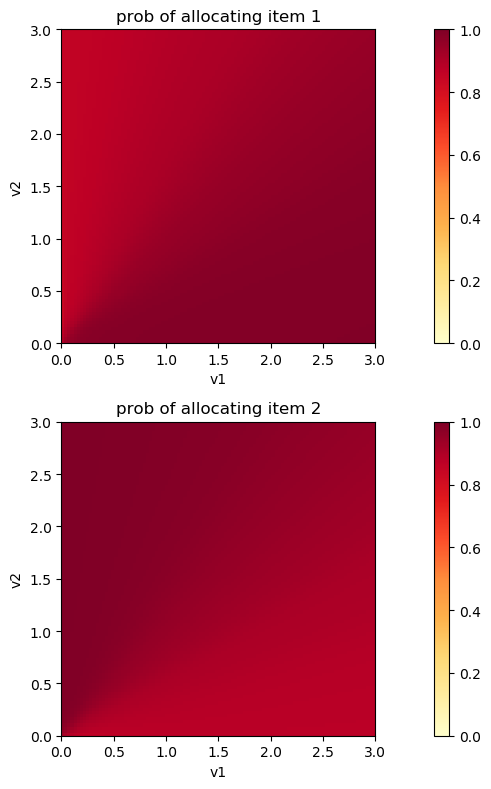

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
# cpu_model.sinkhorn_rounds = 100
# cpu_model.sinkhorn_epsilon = 1e-1
plot_12_model(cpu_model, 0.01, (0,3), (0,3))

In [18]:
cpu_model(torch.tensor([[[1.5, 0.]]]))

(tensor([[[0.9909, 0.8782]]], grad_fn=<ViewBackward>),
 tensor([[0.0088]], grad_fn=<MulBackward0>))

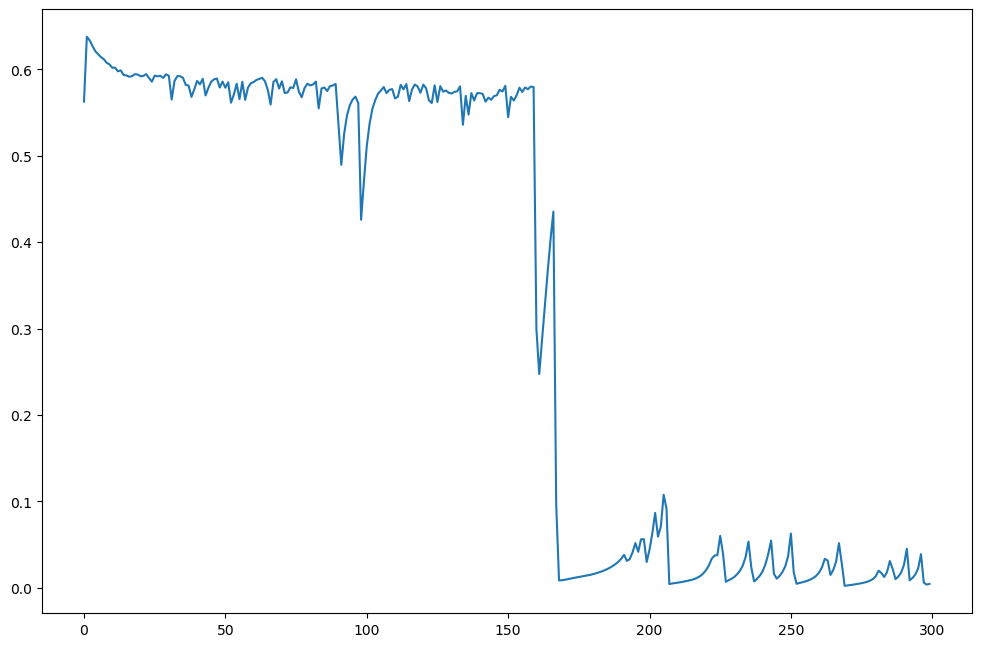

In [19]:
import matplotlib.pyplot as plt
plt.plot(mean_pay)

In [20]:
import pickle
to_pkl_lst = [mean_rgt, mean_pay, lagr_mults]
for i, fname in enumerate(['mean_rgt', 'mean_pay', 'lagr_mults']):
    with open(dir_name + fname, 'wb') as fp:
        pickle.dump(to_pkl_lst[i], fp)